In [1]:
from glob import glob
import matplotlib.pyplot as plt
import gc
import xarray as xr
import pandas as pd
import xrft as xrft
import xroms
import numpy as np
import seawater as sw
import sys
sys.path.append("/homes/metogra/iufarias/FeedbackSubmeso/useful/")
import romspickle


In [2]:

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Lucida Grande']

In [3]:
import warnings

warnings.filterwarnings("ignore")

In [4]:
# client=dask.distributed.Client()
# client

In [5]:

def calc_MLD(dens_int,fillna=2e20,thresh=0.125,coo='z_rho'):
    '''
    dens_int: Interpolated density xarray (from xroms.isoslice)
    '''
    if coo in dens_int.dims:            
        dens_int_new=dens_int.dropna(coo)
        zdic={'{0}'.format(coo):0}
        mld_dens = dens_int_new.isel(zdic)  + thresh
        
        z_indexes = (abs(dens_int_new - mld_dens)).fillna(fillna).argmin(coo)
        mld_f = dens_int_new[coo][z_indexes]
    else:
        print('z_rho dimension not found')
    
    return mld_f

# Reading WRF files

In [5]:
chunks_new={'time_counter':40}

pathf='/data/pacific/lrenault/SASI/FULL/WRF/'
listmw=glob(pathf+'*out*.nc');listmw.sort()
varfw=xr.open_mfdataset(listmw[0],chunks=chunks_new)

In [6]:
chunks_new={'time_counter':40}

pathf='/data/pacific/lrenault/SASI/FULL/WRF/'
listmw=glob(pathf+'wrfout_*.nc');listmw.sort()
varfw=xr.open_mfdataset(listmw[-7:],chunks=chunks_new)

paths='/data/pacific/lrenault/SASI/SMTH/WRF/'
listtw=glob(paths+'wrfout_*.nc');listtw.sort()
vartw=xr.open_mfdataset(listtw[-7:],chunks=chunks_new)

# Reading CROCO files

In [7]:
path='/data/pacific/lrenault/SASI/CROCO/FULL/'
listm=glob(path+'surf*.nc');listm.sort()
# varf=xr.open_dataset(listm[-9:][xmon])
varf=xr.open_mfdataset(listm[1:],data_vars='minimal')

path='/data/pacific/lrenault/SASI/CROCO/SMTH/'
listt=glob(path+'surf*SASI_6h_his_20*_*.nc');listt.sort()
listt.append('/data/pacific/lrenault/SASI/CROCO/SMTH/surf_SASI_6h_his_2012-07.nc')
#vart=xr.open_dataset(listt[xmon])
vart=xr.open_mfdataset(listt[1:],data_vars='minimal')

In [15]:
timer_wrf=pd.DatetimeIndex(varfw.time_counter)
timer_croco_h=pd.DatetimeIndex(varf.time_counter)
timer_croco_d=pd.DatetimeIndex(varf.time_counter.groupby("time_counter.dayofyear").mean())

tim_str=['Jan','Feb','Mar','Apr','May','Jun','Jul']

In [9]:
gc.collect()

28

# Planetary Boundary Layer

In [11]:
dbool=True

In [12]:
pbl_f=varfw['PBLH'][:,20:-20,20:-100]
pbl_t=vartw['PBLH'][:,20:-20,20:-100]

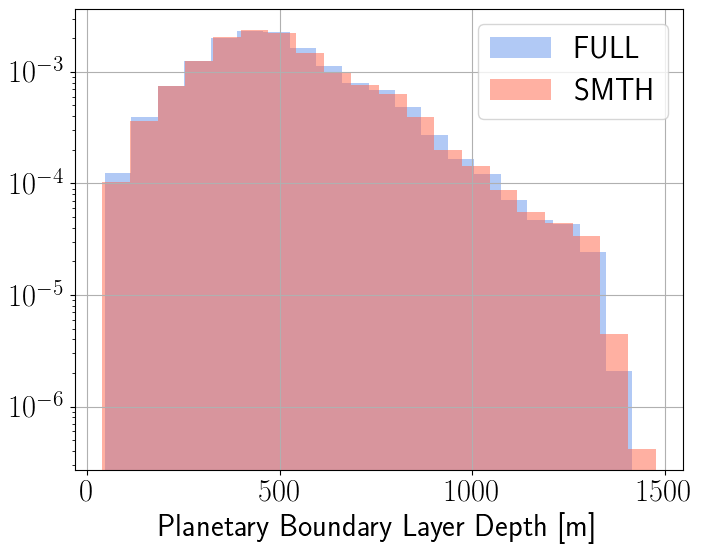

In [112]:
plt.figure(figsize=(7.5,6))

plt.hist(np.ravel(pbl_f),bins=20,color='cornflowerblue',alpha=0.5,density=dbool,label='FULL')
plt.hist(np.ravel(pbl_t),bins=20,color='tomato',alpha=0.5,density=dbool,label='SMTH')
plt.legend()
plt.xlabel('Planetary Boundary Layer Depth [m]')
# plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.tight_layout()

In [148]:
mean_f_mabl,med_f_mabl,std_f_mabl=np.nanmean(pbl_f),np.nanmedian(pbl_f),np.nanstd(pbl_f)
mean_t_mabl,med_t_mabl,std_t_mabl=np.nanmean(pbl_t),np.nanmedian(pbl_t),np.nanstd(pbl_t)

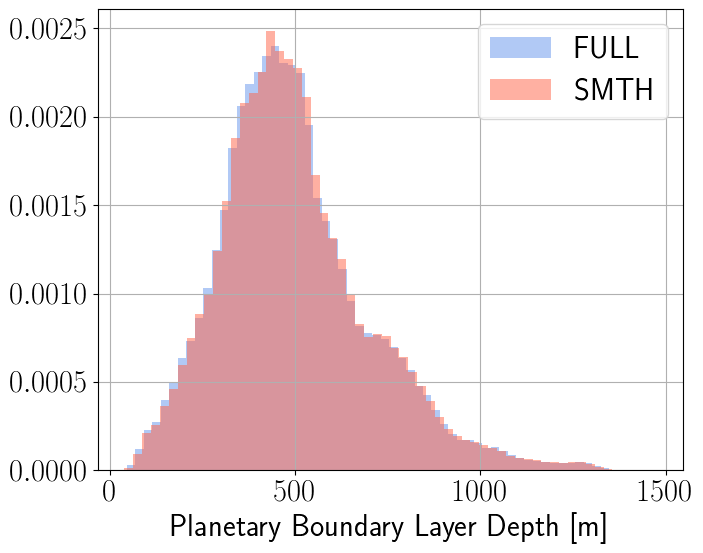

In [113]:
plt.figure(figsize=(7.5,6))


pbl_f.plot.hist(bins=60,color='cornflowerblue',alpha=0.5,density=dbool,label='FULL')
pbl_t.plot.hist(bins=60,color='tomato',alpha=0.5,density=dbool,label='SMTH')
plt.legend()
plt.xlabel('Planetary Boundary Layer Depth [m]')

plt.grid()
plt.tight_layout()
# plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/MLD+PBL/histogram_PBL.png')

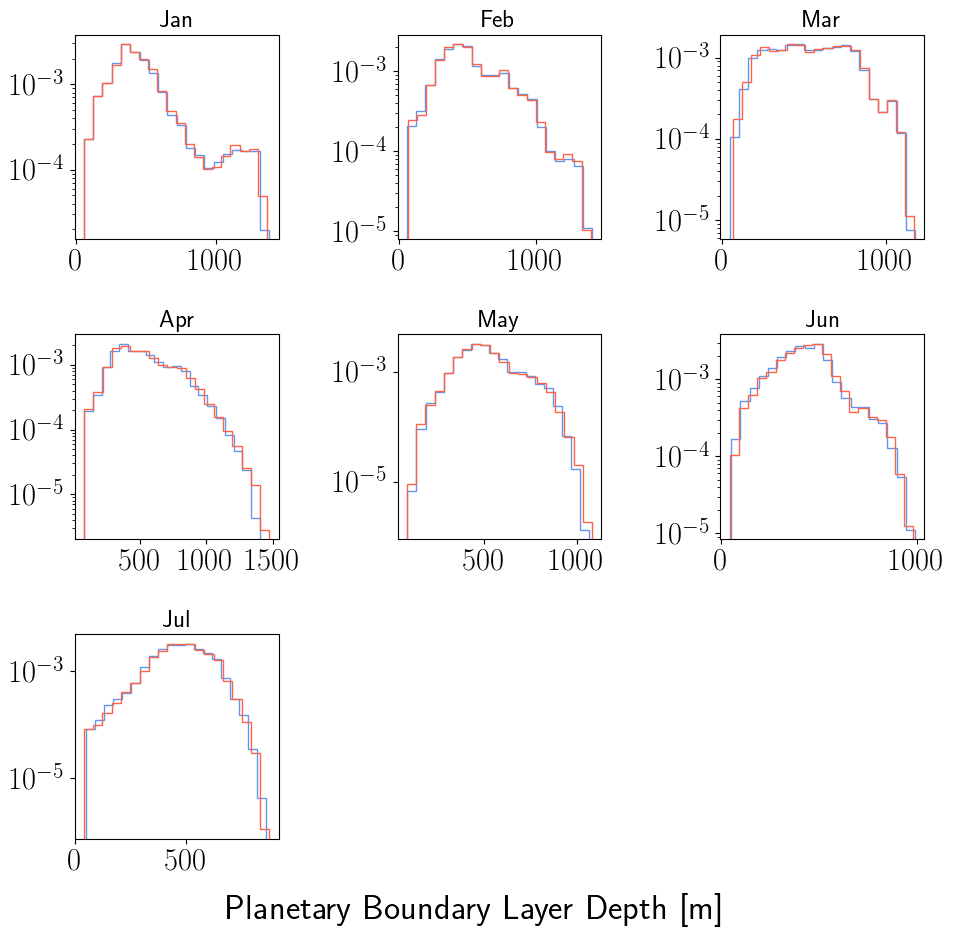

In [118]:
fig=plt.figure(figsize=(10,10))

for im in np.arange(7):
    plt.subplot(3,3,im+1)
    pbl_f[timer_wrf.month==im+1].plot.hist(bins=20,color='cornflowerblue',linewidth=lw,alpha=a1,histtype=HT,density=dbool,label='FULL')
    pbl_t[timer_wrf.month==im+1].plot.hist(bins=20,color='tomato',linewidth=lw,alpha=a1,histtype=HT,density=dbool,label='SMTH')
    plt.xlabel('')
    plt.ylabel('')
    # plt.ylim(0,2e5)
    # plt.yticks([1e5,2e5],labels=[r'$1$x$10^5$',r'$2$x$10^5$'])
    plt.title(tim_str[im],fontweight='normal',fontsize=18)
    plt.yscale('log')
fig.supxlabel('Planetary Boundary Layer Depth [m]',fontsize=25,y=0.05)

plt.tight_layout()
# plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/MLD+PBL/histogram_PBL_monthly.png')

## Map Plots

In [16]:
plt.figure(figsize=(10,10))
cb=(pbl_f-pbl_t)[::10].plot(y='nav_lat_grid_M',x='nav_lon_grid_M',levels=np.linspace(-200,200,55),col='time_counter',col_wrap=4,cmap='seismic')
cb.set_xlabels('')
cb.set_ylabels('')
# cb.set_titles('')

for i, ax in enumerate(cb.axes.flat):
    try:
        ax.set_title("dayofyear=%d" %np.arange(1,214)[::10][i])
    except:
        print('no figures')

# plt.xlabel('')
# plt.ylabel('')
# plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/MLD+PBL/PBL_time_panel.png')


In [17]:
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.contourf(pbl_f.nav_lon_grid_M,pbl_f.nav_lat_grid_M,pbl_f.mean(axis=0),cmap='rainbow',levels=np.linspace(300,600,55))
cba1=plt.colorbar()
plt.title('FULL',fontsize=15)
cba1.set_ticks([300,400,500,600])
cba1.set_label('PBL [m]',fontsize=15)

plt.subplot(2,2,2)
plt.contourf(pbl_t.nav_lon_grid_M,pbl_t.nav_lat_grid_M,pbl_t.mean(axis=0),cmap='rainbow',levels=np.linspace(300,600,55))
plt.title('SMTH',fontsize=15)
cba2=plt.colorbar()
cba2.set_ticks([300,400,500,600])
cba2.set_label('PBL [m]',fontsize=15)

mpp=pbl_t.mean().compute()
plt.subplot(2,2,3)
plt.contourf(pbl_f.nav_lon_grid_M,pbl_f.nav_lat_grid_M,(pbl_f.mean(axis=0)-pbl_t.mean(axis=0))/mpp*100,
             cmap='seismic_r',levels=np.linspace(-10,10,35))
plt.title('FULL - SMTH',fontsize=15)

cba3=plt.colorbar()
cba3.set_ticks([-10,-5,0,5,10])
cba3.set_label(r'[\%]',fontsize=15)




plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/MLD+PBL/PBL_maps.png')

## Mixed Layer Depth

In [10]:
# hbl_f=varf['hbl'][:,120:-120,120:800].groupby("time_counter.dayofyear").mean().compute()
# hbl_t=vart['hbl'][:,120:-120,120:800].groupby("time_counter.dayofyear").mean().compute()
hbl_f=varf['hbl'][:,120:-120,120:800].compute()
hbl_t=vart['hbl'][:,120:-120,120:800].compute()

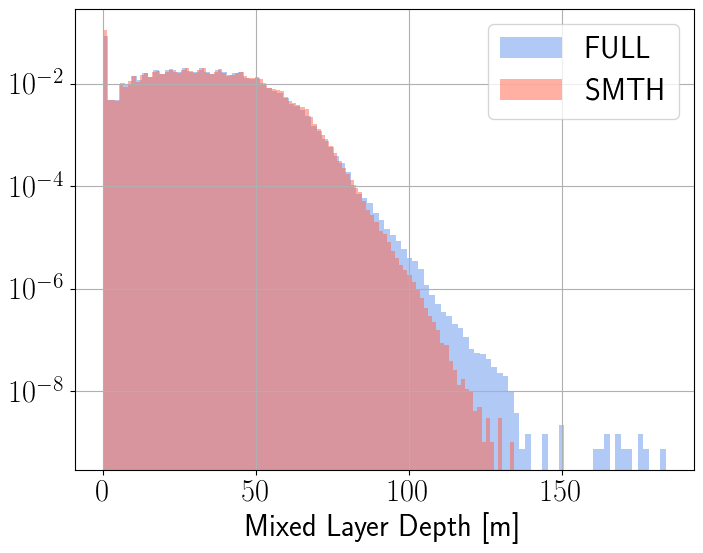

In [11]:
logs=True
dbool=True
plt.figure(figsize=(7.5,6))
hbl_f.plot.hist(bins=100,color='cornflowerblue',alpha=0.5,density=dbool,label='FULL',log=logs)
hbl_t.plot.hist(bins=100,color='tomato',alpha=0.5,density=dbool,label='SMTH',log=logs)


# hbl_f.mean(axis=0).plot.hist(bins=20,color='cornflowerblue',alpha=0.5,density=True,label='FULL')
# hbl_t.mean(axis=0).plot.hist(bins=20,color='orange',alpha=0.5,density=True,label='SMTH')

plt.legend()
plt.xlabel('Mixed Layer Depth [m]')
plt.grid()
# plt.xlim(0,120)
plt.tight_layout()
# plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/MLD+PBL/histogram_MLD_log.png')

In [12]:
mean_f_hbl,med_f_hbl,std_f_hbl=np.nanmean(hbl_f),np.nanmedian(hbl_f),np.nanstd(hbl_f)
mean_t_hbl,med_t_hbl,std_t_hbl=np.nanmean(hbl_t),np.nanmedian(hbl_t),np.nanstd(hbl_t)

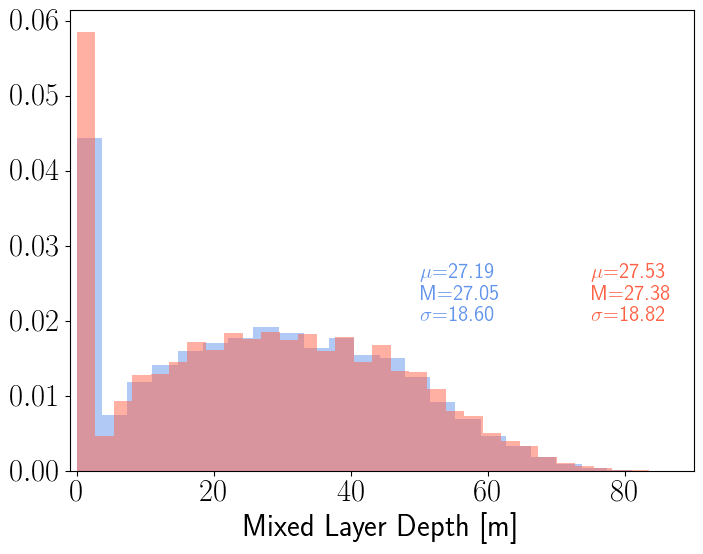

In [13]:

logs=False
dbool=True


plt.figure(figsize=(7.5,6))
hbl_f.plot.hist(bins=50,color='cornflowerblue',alpha=0.5,density=dbool,label='FULL',log=logs)
hbl_t.plot.hist(bins=50,color='tomato',alpha=0.5,density=dbool,label='SMTH',log=logs)
plt.text(50,0.02,r' $\mu$' + '={0:.2f} \n'.format(mean_f_hbl)+ r'M' + '={0:.2f} \n'.format(med_f_hbl) + r'$\sigma$'+'={0:.2f}'.format(std_f_hbl),color='cornflowerblue',fontsize=15)
plt.text(75,0.02,r' $\mu$' + '={0:.2f} \n'.format(mean_t_hbl)+ r'M' + '={0:.2f} \n'.format(med_t_hbl) + r'$\sigma$'+'={0:.2f}'.format(std_t_hbl),color='tomato',fontsize=15) 

# plt.legend()
plt.xlabel('Mixed Layer Depth [m]')
# plt.grid()
plt.xlim(-1,90)
plt.tight_layout()
# plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/MLD+PBL/histogram_MLD.png')

IndexError: Boolean array size 214 is used to index array with shape (852, 1280, 680).

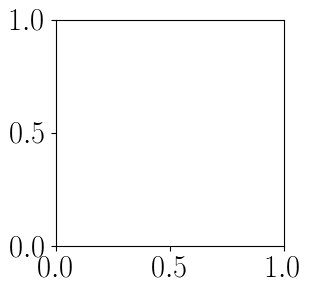

In [16]:
fig=plt.figure(figsize=(10,10))

for im in np.arange(7):
    plt.subplot(3,3,im+1)
    hbl_f[timer_croco_d.month==im+1].plot.hist(bins=40,color='cornflowerblue',linewidth=lw,alpha=a1,histtype=HT,density=dbool,label='FULL')
    hbl_t[timer_croco_d.month==im+1].plot.hist(bins=40,color='tomato',linewidth=lw,alpha=a2,histtype=HT,density=dbool,label='SMTH')
    plt.xlabel('')
    plt.ylabel('')
    plt.title(tim_str[im],fontweight='normal',fontsize=18)
    # plt.xlim(-1,100)
    # plt.ylim(0,2e6)
    # plt.xticks([0,50,100])


fig.supxlabel('Mixed Layer Depth [m]',fontsize=25,y=0.05)

plt.tight_layout()
# plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/MLD+PBL/histogram_MLD_monthly.png')

## Panel PBL and MLD

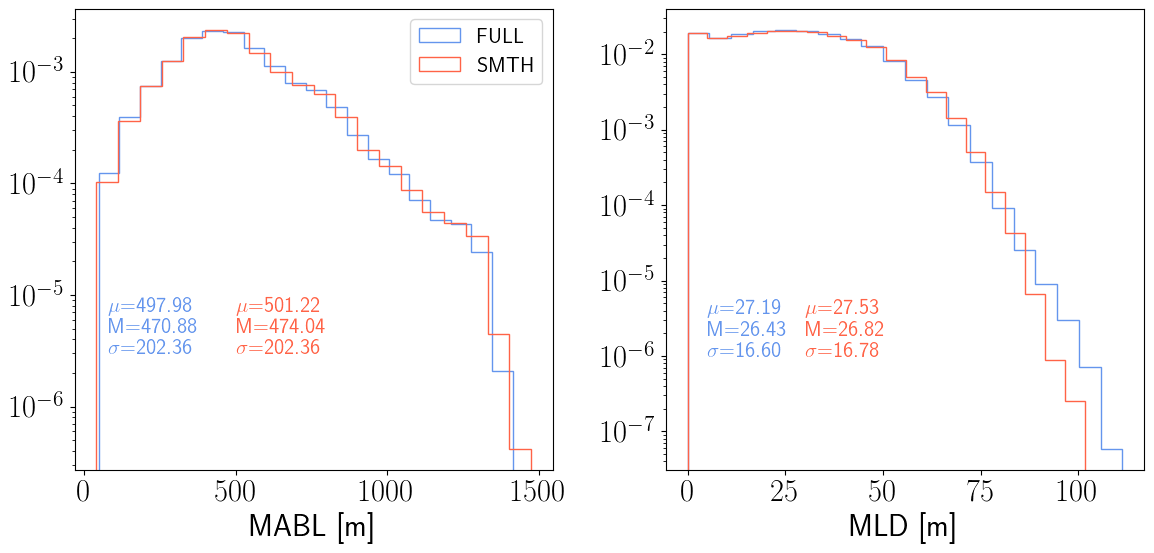

In [153]:
dbool=True
slog=True

a1=1
a2=1
lw=1
HT='step'

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)

plt.hist(np.ravel(pbl_f),bins=20,color='cornflowerblue',linewidth=lw,alpha=a1,histtype=HT,density=dbool,label='FULL')
plt.hist(np.ravel(pbl_t),bins=20,color='tomato',linewidth=lw,alpha=a1,histtype=HT,density=dbool,label='SMTH')
plt.legend(fontsize=15)
plt.text(80,3e-6,r' $\mu$' + '={0:.2f} \n'.format(mean_f_mabl)+ r'M' + '={0:.2f} \n'.format(med_f_mabl) + r'$\sigma$'+'={0:.2f}'.format(std_f_mabl),color='cornflowerblue',fontsize=15)
plt.text(500,3e-6,r' $\mu$' + '={0:.2f} \n'.format(mean_t_mabl)+ r'M' + '={0:.2f} \n'.format(med_t_mabl) + r'$\sigma$'+'={0:.2f}'.format(std_t_mabl),color='tomato',fontsize=15) 




plt.xlabel('MABL [m]')
# plt.xscale('log')
plt.yscale('log')


plt.subplot(1,2,2)
hbl_f.plot.hist(bins=20,color='cornflowerblue',linewidth=lw,alpha=a1,histtype=HT,density=dbool,label='FULL',log=slog)
hbl_t.plot.hist(bins=20,color='tomato',linewidth=lw,alpha=a1,histtype=HT,density=dbool,label='SMTH',log=slog)
plt.text(5,1e-6,r' $\mu$' + '={0:.2f} \n'.format(mean_f_hbl)+ r'M' + '={0:.2f} \n'.format(med_f_hbl) + r'$\sigma$'+'={0:.2f}'.format(std_f_hbl),color='cornflowerblue',fontsize=15)
plt.text(30,1e-6,r' $\mu$' + '={0:.2f} \n'.format(mean_t_hbl)+ r'M' + '={0:.2f} \n'.format(med_t_hbl) + r'$\sigma$'+'={0:.2f}'.format(std_t_hbl),color='tomato',fontsize=15) 



plt.xlabel('MLD [m]')



plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/MLD+PBL/LayerDepthPanel_log.png')



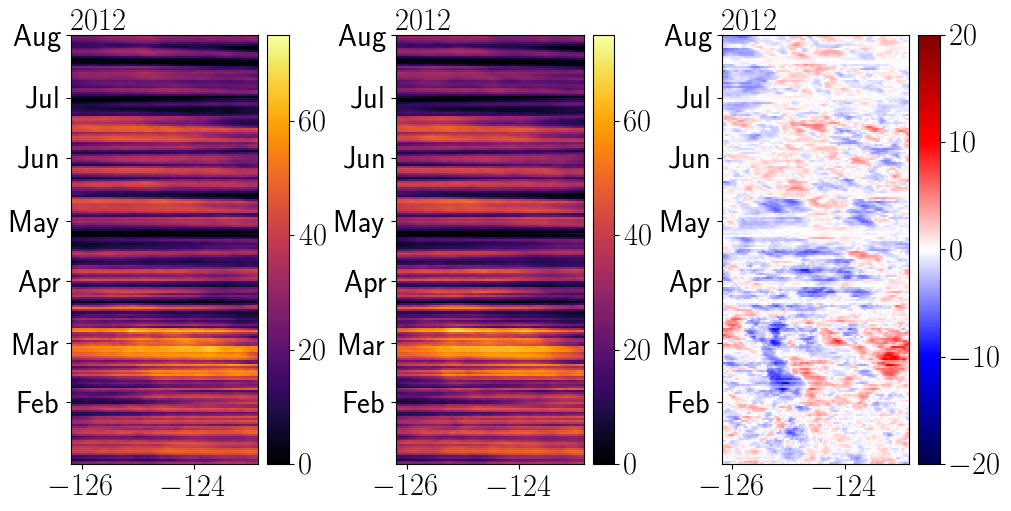

In [72]:
import matplotlib.dates as mdates


# fig,ax=plt.subplots(3,1,figsize=(10, 6), layout='constrained')
fig,ax=plt.subplots(1,3,figsize=(10,5), layout='constrained')


cc=ax[0].pcolormesh(hbl_f.nav_lon_rho.mean(axis=0),timer_croco_d,hbl_f.mean(axis=1),vmin=0,vmax=75,cmap='inferno')

ax[0].yaxis.set_major_formatter(mdates.ConciseDateFormatter(ax[0].yaxis.get_major_locator()))
fig.colorbar(cc, ax=ax[0])

cc1=ax[1].pcolormesh(hbl_t.nav_lon_rho.mean(axis=0),timer_croco_d,hbl_t.mean(axis=1),vmin=0,vmax=75,cmap='inferno')
ax[1].yaxis.set_major_formatter(mdates.ConciseDateFormatter(ax[1].yaxis.get_major_locator()))
fig.colorbar(cc1, ax=ax[1])





cc2=ax[2].pcolormesh(hbl_t.nav_lon_rho.mean(axis=0),timer_croco_d,hbl_f.mean(axis=1)-hbl_t.mean(axis=1),vmin=-20,vmax=20,cmap='seismic')
ax[2].yaxis.set_major_formatter(mdates.ConciseDateFormatter(ax[1].yaxis.get_major_locator()))
fig.colorbar(cc2, ax=ax[2])


plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/MLD+PBL/timeseries_x_MLD.png')

# plt.tight_layout()

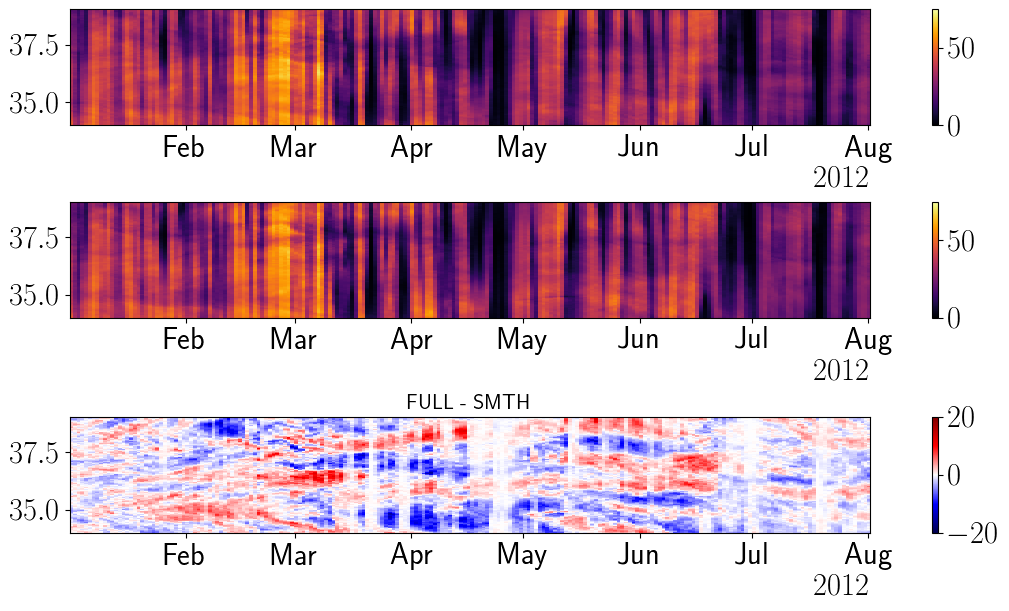

In [73]:

fig,ax=plt.subplots(3,1,figsize=(10,6), layout='constrained')

cc=ax[0].pcolormesh(timer_croco_d,hbl_f.nav_lat_rho.mean(axis=1),hbl_f.mean(axis=2).T,vmin=0,vmax=75,cmap='inferno')

ax[0].xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax[0].xaxis.get_major_locator()))
fig.colorbar(cc, ax=ax[0])

cc1=ax[1].pcolormesh(timer_croco_d,hbl_t.nav_lat_rho.mean(axis=1),hbl_t.mean(axis=2).T,vmin=0,vmax=75,cmap='inferno')
ax[1].xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax[1].xaxis.get_major_locator()))
fig.colorbar(cc1, ax=ax[1])




ax[2].set_title('FULL - SMTH',fontsize=15)
cc2=ax[2].pcolormesh(timer_croco_d,hbl_t.nav_lat_rho.mean(axis=1),hbl_f.mean(axis=2).T-hbl_t.mean(axis=2).T,vmin=-20,vmax=20,cmap='seismic')
ax[2].xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax[1].xaxis.get_major_locator()))
fig.colorbar(cc2, ax=ax[2])

plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/MLD+PBL/timeseries_y_MLD.png')





## Map Plots

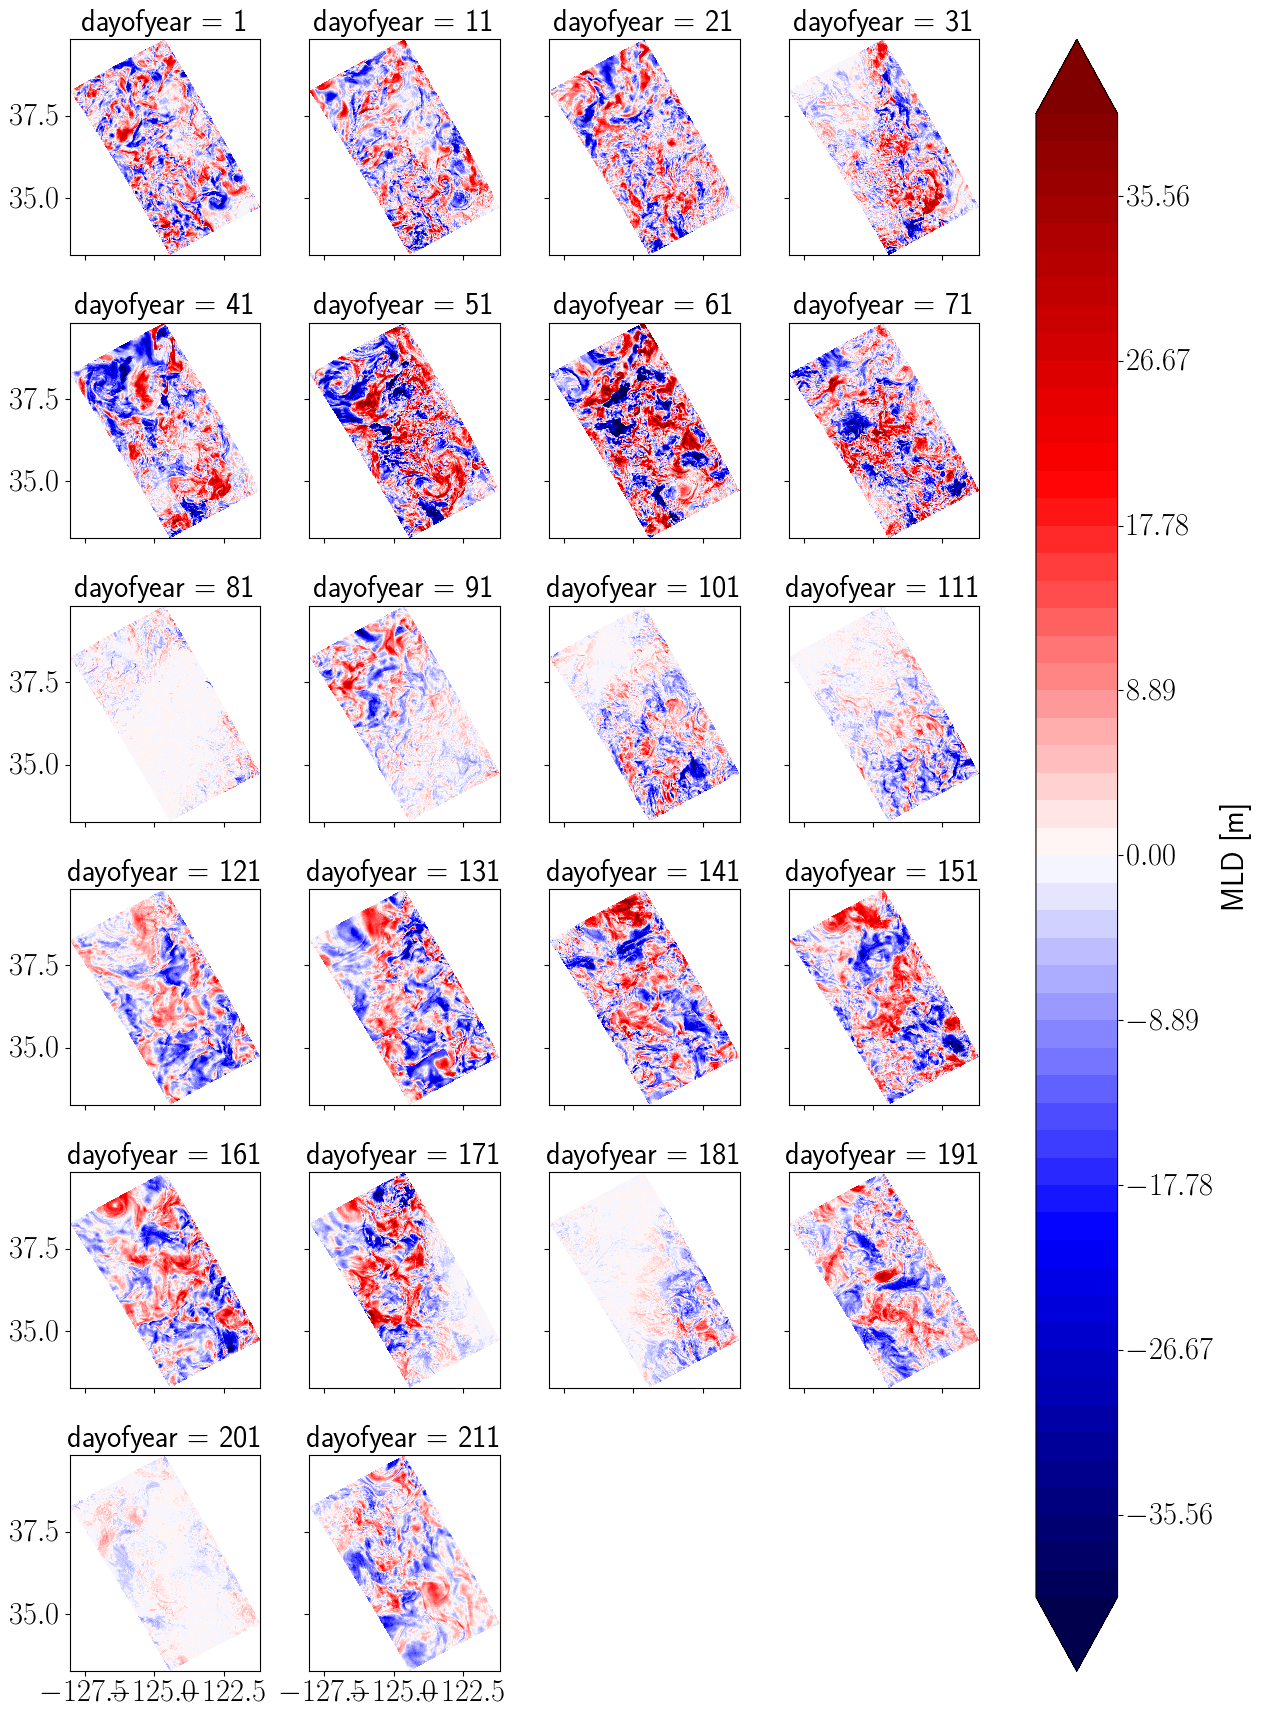

In [155]:
cb=(hbl_f-hbl_t)[::10].plot(y='nav_lat_rho',x='nav_lon_rho',col='dayofyear',col_wrap=4,
                            levels=np.linspace(-40,40,55),cmap='seismic',cbar_kwargs={"label": "MLD [m]"})
cb.set_xlabels('')
cb.set_ylabels('')


# plt.xlabel('')
# plt.ylabel('')
# plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/MLD+PBL/MLD_time_panel.png')

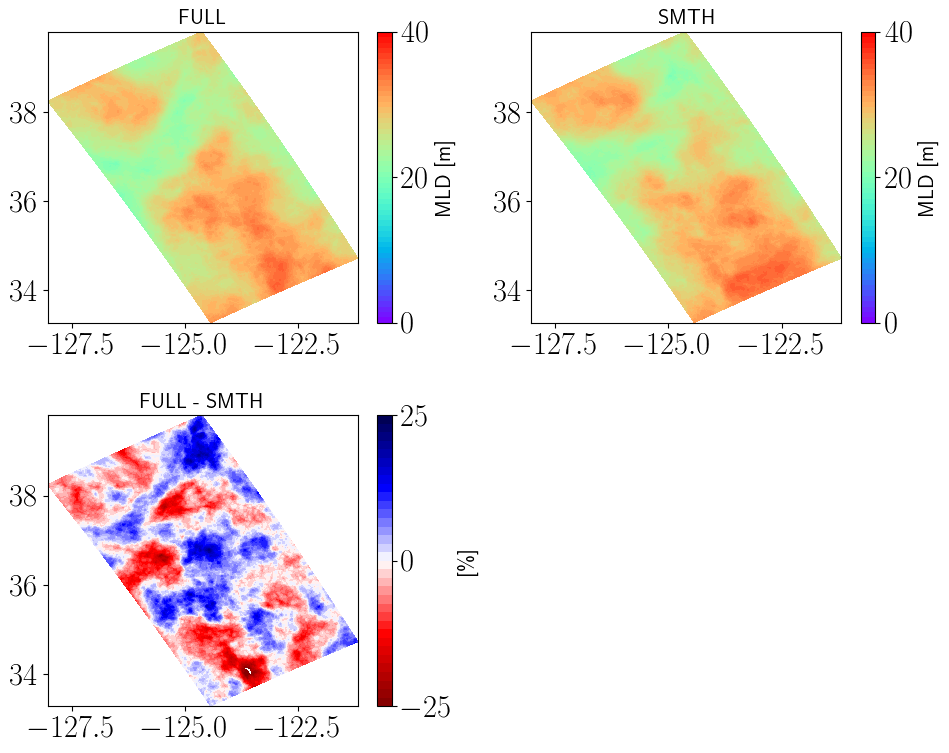

In [51]:
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.contourf(hbl_f.nav_lon_rho,hbl_f.nav_lat_rho,hbl_f.mean(axis=0),cmap='rainbow',levels=np.linspace(0,40,55))
cba1=plt.colorbar()
plt.title('FULL',fontsize=15)
cba1.set_ticks([0,20,40])
cba1.set_label('MLD [m]',fontsize=15)


plt.subplot(2,2,2)
plt.contourf(hbl_t.nav_lon_rho,hbl_t.nav_lat_rho,hbl_t.mean(axis=0),cmap='rainbow',levels=np.linspace(0,40,55))
cba1=plt.colorbar()
plt.title('SMTH',fontsize=15)
cba1.set_ticks([0,20,40])
cba1.set_label('MLD [m]',fontsize=15)


mdd=hbl_t.mean().compute()

plt.subplot(2,2,3)
plt.contourf(hbl_f.nav_lon_rho,hbl_f.nav_lat_rho,(hbl_f.mean(axis=0)-hbl_t.mean(axis=0))/mdd*100,
             cmap='seismic_r',levels=np.linspace(-25,25,35))
cba1=plt.colorbar()
plt.title('FULL - SMTH',fontsize=15)
cba1.set_ticks([-25,0,25])
cba1.set_label(r'[\%]',fontsize=15)
# plt.colorbar()

plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/MLD+PBL/MLD_maps.png')

# Submesoscale Parameters - Histograms

In [15]:
chunks_new={'dayofyear':40}
dx=500

In [28]:
%%time
uf=varf.u.groupby("time_counter.dayofyear").mean()
uf=uf.chunk(chunks=chunks_new);
# u_f=(uf[:,1:,:]+uf[:,:-1,:])/2
uf=uf.compute();

ut=vart.u.groupby("time_counter.dayofyear").mean()
ut=ut.chunk(chunks=chunks_new);
# ut=(ut[:,1:,:]+ut[:,:-1,:])/2
ut=ut.compute();

vf=varf.v.groupby("time_counter.dayofyear").mean()
vf=vf.chunk(chunks=chunks_new);
# vf=(vf[:,:,1:]+vf[:,:,:-1])/2
vf=vf.compute();

vt=vart.v.groupby("time_counter.dayofyear").mean()
vt=vt.chunk(chunks=chunks_new);
# vt=(vt[:,:,1:]+vt[:,:,:-1])/2
vt=vt.compute();



CPU times: user 56.1 s, sys: 1min 1s, total: 1min 58s
Wall time: 17.2 s


In [29]:
uf,vf,_=romspickle.uvw2rho_3d(uf,vf,uf)
uf,vf=uf[:,120:-120,120:800],vf[:,120:-120,120:800]

ut,vt,_=romspickle.uvw2rho_3d(ut,vt,ut)
ut,vt=ut[:,120:-120,120:800],vt[:,120:-120,120:800]

In [30]:
f=sw.f(hbl_f.nav_lat_rho[1:-1,:])

In [31]:
zeta_f=np.gradient(vf,axis=2)/dx -np.gradient(uf,axis=1)/dx
zeta_t=np.gradient(vt,axis=2)/dx -np.gradient(ut,axis=1)/dx

In [32]:
div_f=np.gradient(uf,axis=2)/dx +np.gradient(vf,axis=1)/dx
div_t=np.gradient(ut,axis=2)/dx +np.gradient(vt,axis=1)/dx

In [33]:

tf=varf.temp.groupby("time_counter.dayofyear").mean()
tf=tf.chunk(chunks=chunks_new);
tf=tf[:,120:-120,120:800].compute();

tt=vart.temp.groupby("time_counter.dayofyear").mean()
tt=tt.chunk(chunks=chunks_new);
tt=tt[:,120:-120,120:800].compute();

sf=varf.salt.groupby("time_counter.dayofyear").mean()
sf=sf.chunk(chunks=chunks_new);
sf=sf[:,120:-120,120:800].compute();

st=vart.salt.groupby("time_counter.dayofyear").mean()
st=st.chunk(chunks=chunks_new);
st=st[:,120:-120,120:800].compute();

In [34]:
import xroms 

rhof=xroms.potential_density(tf,sf)
rhot=xroms.potential_density(tt,st)

In [35]:
bf=xroms.buoyancy(rhof-1025)#[:,1:-1,:]
bt=xroms.buoyancy(rhot-1025)#[:,1:-1,:]

In [37]:
bx_f=(np.gradient(bf[:,1:-1,:],axis=2)/dx)
by_f=(np.gradient(bf[:,1:-1,:],axis=1)/dx)

bx_t=(np.gradient(bt[:,1:-1,:],axis=2)/dx)
by_t=(np.gradient(bt[:,1:-1,:],axis=1)/dx)

In [38]:
bM_f=np.sqrt(bx_f**2+by_f**2)
bM_t=np.sqrt(bx_t**2+by_t**2)

In [56]:
mean_f_z,med_f_z,std_f_z=np.nanmean(zeta_f/f),np.nanmedian(zeta_f/f),np.nanstd(zeta_f/f)
mean_t_z,med_t_z,std_t_z=np.nanmean(zeta_t/f),np.nanmedian(zeta_t/f),np.nanstd(zeta_t/f)


mean_f_div,med_f_div,std_f_div=np.nanmean(div_f/f),np.nanmedian(div_f/f),np.nanstd(div_f/f)
mean_t_div,med_t_div,std_t_div=np.nanmean(div_t/f),np.nanmedian(div_t/f),np.nanstd(div_t/f)

mean_f_gb,med_f_gb,std_f_gb=np.nanmean(bM_f/f**2),np.nanmedian(bM_f/f**2),np.nanstd(bM_f/f**2)
mean_t_gb,med_t_gb,std_t_gb=np.nanmean(bM_t/f**2),np.nanmedian(bM_t/f**2),np.nanstd(bM_t/f**2)


mean_f_b,med_f_b,std_f_b=np.nanmean(bf),np.nanmedian(bf),np.nanstd(bf)
mean_t_b,med_t_b,std_t_b=np.nanmean(bt),np.nanmedian(bt),np.nanstd(bt)



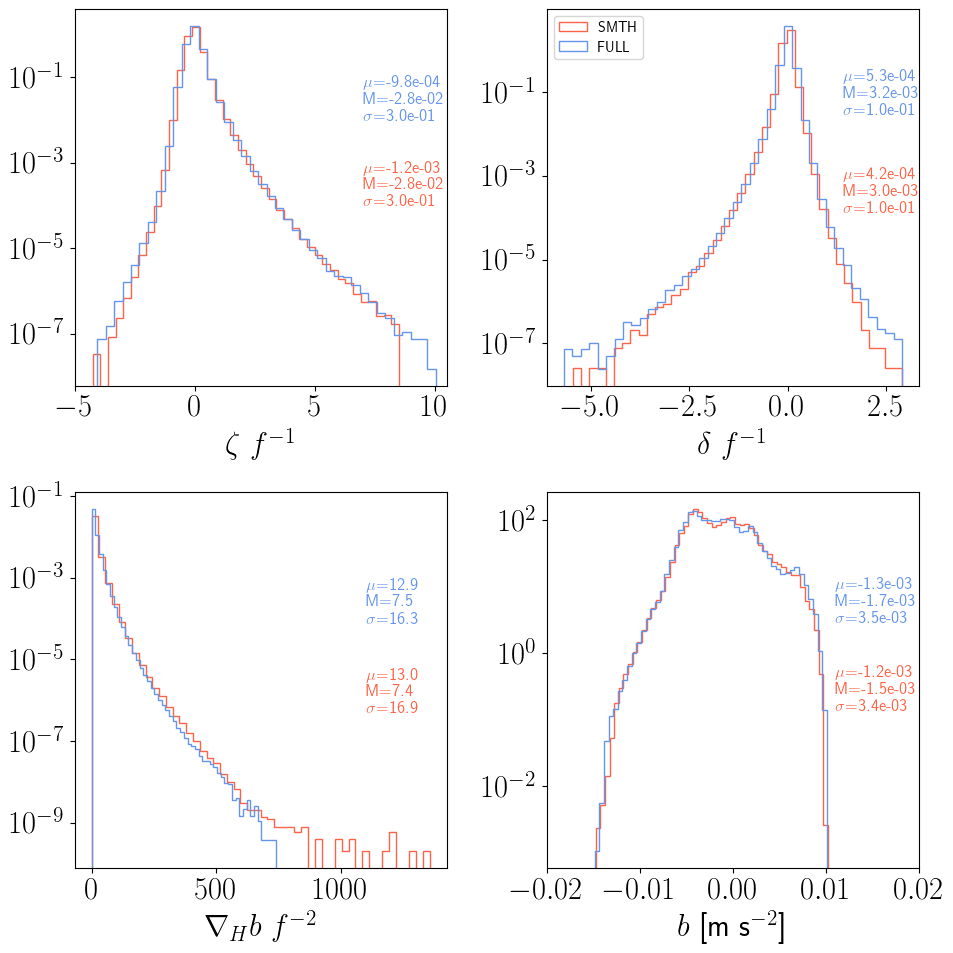

In [111]:
dbool=True
slog=True

a1=1
a2=1
lw=1
HT='step'

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.hist(np.ravel(zeta_t/f),bins=40,color='tomato',linewidth=lw,histtype=HT,alpha=a2,density=dbool,log=slog)
plt.hist(np.ravel(zeta_f/f),bins=40,color='cornflowerblue',linewidth=lw,histtype=HT,alpha=a1,density=dbool,log=slog)


plt.text(7,1e-2,r' $\mu$' + '={0:.1e} \n'.format(mean_f_z)+ r'M' + '={0:.1e} \n'.format(med_f_z) + r'$\sigma$'+'={0:.1e}'.format(std_f_z),color='cornflowerblue',fontsize=12)
plt.text(7,1e-4,r' $\mu$' + '={0:.1e} \n'.format(mean_t_z)+ r'M' + '={0:.1e} \n'.format(med_t_z) + r'$\sigma$'+'={0:.1e}'.format(std_t_z),color='tomato',fontsize=12) 
plt.xlim(-5,10.5)
plt.xlabel(r'$\zeta$ $f^{-1}$')


plt.subplot(2,2,2)
plt.hist(np.ravel(div_t/f),bins=40,color='tomato',linewidth=lw,histtype=HT,alpha=a2,label='SMTH',density=dbool,log=slog)
plt.hist(np.ravel(div_f/f),bins=40,color='cornflowerblue',linewidth=lw,histtype=HT,alpha=a1,label='FULL',density=dbool,log=slog)
plt.legend(fontsize=10,loc=2)



plt.text(1.4,3e-2,r' $\mu$' + '={0:.1e} \n'.format(mean_f_div)+ r'M' + '={0:.1e} \n'.format(med_f_div) + r'$\sigma$'+'={0:.1e}'.format(std_f_div),color='cornflowerblue',fontsize=12)
plt.text(1.4,1.4e-4,r' $\mu$' + '={0:.1e} \n'.format(mean_t_div)+ r'M' + '={0:.1e} \n'.format(med_t_div) + r'$\sigma$'+'={0:.1e}'.format(std_t_div),color='tomato',fontsize=12) 
# plt.xlim(-2.5,2.5)
plt.xlabel(r'$\delta$ $f^{-1}$')


plt.subplot(2,2,3)
plt.hist(np.ravel(bM_t/f**2),bins=50,color='tomato',linewidth=lw,histtype=HT,alpha=a2,density=dbool,log=slog)
plt.hist(np.ravel(bM_f/f**2),bins=50,color='cornflowerblue',linewidth=lw,histtype=HT,alpha=a1,density=dbool,log=slog)


plt.text(1100,8e-5,r' $\mu$' + '={0:.1f} \n'.format(mean_f_gb)+ r'M' + '={0:.1f} \n'.format(med_f_gb) + r'$\sigma$'+'={0:.1f}'.format(std_f_gb),color='cornflowerblue',fontsize=12)
plt.text(1100,5e-7,r' $\mu$' + '={0:.1f} \n'.format(mean_t_gb)+ r'M' + '={0:.1f} \n'.format(med_t_gb) + r'$\sigma$'+'={0:.1f}'.format(std_t_gb),color='tomato',fontsize=12) 
# plt.xlim(0,150)
plt.xlabel(r'$\nabla_H b$ $f^{-2}$')


plt.subplot(2,2,4)
plt.hist(np.ravel(bt),bins=50,color='tomato',linewidth=lw,histtype=HT,alpha=a2,density=dbool,log=slog)
plt.hist(np.ravel(bf),bins=50,color='cornflowerblue',linewidth=lw,histtype=HT,alpha=a1,density=dbool,log=slog)


plt.text(0.011,3e0,r' $\mu$' + '={0:.1e} \n'.format(mean_f_b)+ r'M' + '={0:.1e} \n'.format(med_f_b) + r'$\sigma$'+'={0:.1e}'.format(std_f_b),color='cornflowerblue',fontsize=12)
plt.text(0.011,1.4e-1,r' $\mu$' + '={0:.1e} \n'.format(mean_t_b)+ r'M' + '={0:.1e} \n'.format(med_t_b) + r'$\sigma$'+'={0:.1e}'.format(std_t_b),color='tomato',fontsize=12) 


plt.xlabel(r'$b$ [m s$^{-2}$]')
plt.xlim(-0.02,0.02)


plt.tight_layout()

plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/MLD+PBL/histograms_assessment_log.png')
